## Decomposition of moisture transport 

- timeseries only within 3000 
- convective vs. stratiform precipitation 


- plot climatological water transport 
- mean flow vs. eddies 

In [203]:
import xarray as xr 
import matplotlib.pyplot as plt 
import numpy as np 
import quiver 
import matplotlib.colors as colors
import cartopy.crs as ccrs
import atmotrans as atm 
from atmotrans import R,c

In [109]:
## elevation for contour of TP 
import xarray
dem = '/media/juli/Data/projects/data/elevation/elevation_600x350.nc'
elevations = xarray.open_dataarray(dem)

In [72]:
awt = 'tmpdir/monthly/awt_clim06.nc'
awt_may = xr.open_dataset(awt)
awt_u= awt_may['p71.162'][0]
awt_v= awt_may['p72.162'][0]
q= np.abs(awt_u) + np.abs(awt_v)

lons = awt_may['longitude']
lats = awt_may['latitude']

# convert coords to 2d array 
x,y = np.meshgrid(lons, lats)


## Monthly climatology 

In [96]:
def quick_plot(data):
    plt.figure(figsize=(15,6))
    ax = plt.axes(projection=ccrs.PlateCarree())
    m = plt.pcolormesh(lons,lats, data, transform= ccrs.PlateCarree())
    plt.colorbar()

In [119]:
def plot_awt(awt_u, awt_v, q):
    plt.figure(figsize=(15,6))
    ax = plt.axes(projection=ccrs.PlateCarree())
    
    m = plt.pcolormesh(lons, lats, q, transform= ccrs.PlateCarree(), cmap = 'viridis')
    ax.set_extent([50,130,10,50])
    ax.coastlines(linewidth = 1.5)
    plt.contour(elevations.lon.values,elevations.lat.values, elevations.data.T, [3000], cmap = 'Greys_r')

    # Normalise the data for uniform arrow size
    u_norm = awt_u/ np.sqrt(awt_u ** 2.0 + awt_u ** 2.0)
    v_norm = awt_v / np.sqrt(awt_v ** 2.0 + awt_v ** 2.0)

    # Plot wind vectors 
    skip  =(slice(None,None,10),slice(None,None,10))
    plt.quiver(x[skip],y[skip],awt_u[skip], awt_v[skip], color ='k', transform= ccrs.PlateCarree())

    cbar = plt.colorbar(m, label = 'water vapour flux kg m$^{-1}$ s$^{-1}$')

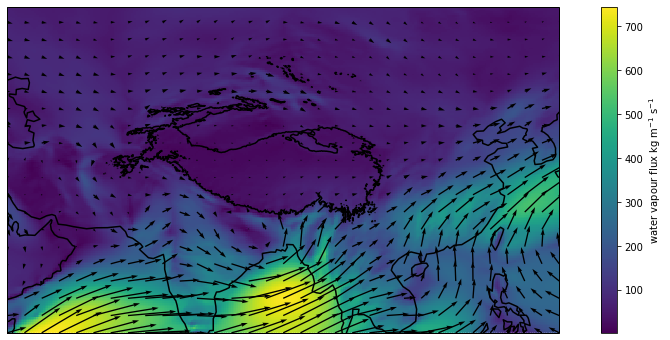

In [120]:
plot_awt(awt_u, awt_v, q)

## Mean flow vs. eddies 

In [174]:
import glob
# surface pressures 
sp_files= glob.glob('tmpdir/monthly/*srfc_pressure*')
sp_files.sort()

# monthly primes
uprim_files = glob.glob('tmpdir/processed/qu*prim*nc')
vprim_files = glob.glob('tmpdir/processed/qv*prim*nc')
uprim_files.sort()
vprim_files.sort()

# monthly mean qV
monmean_files = glob.glob('tmpdir/monthly/test/*temperature-geopotential-specific_cloud_ice_water*nc') 
monmean_files.sort()

In [193]:
# preprocessing: get spacings 
lats= xr.open_dataset(monmean_files[0])['latitude'].values
lons= xr.open_dataset(monmean_files[0])['longitude'].values
dlat, dlon= atm.get_spacing(lats, lons)

# get pressure levels 
pressure =  xr.open_dataset(monmean_files[0])['level'].values

In [199]:
# initialize 
conv_mean = np.zeros((201,321))
conv_eddy = np.zeros((201,321))

for ymon in np.arange(20):
    print(ymon)
    # read in all mean fields 
    spdata= xr.open_dataset(sp_files[ymon])
    fields =xr.open_dataset(monmean_files[ymon])
    u = fields.u[0].values
    v = fields.v[0].values
    t = fields.t[0].values
    z = fields.z[0].values
    # specific humidity (water vapour in kg/kg)
    q = fields.q[0].values + fields.clwc[0].values + fields.clwc[0].values
    # surface pressure values 
    sp = spdata.sp[0].values /100
    fields.close()
    spdata.close()
############################## mean flow ############################

    # set geopotential to 0, where surface pressure < 1000 hpa 
    coords = np.where(sp < 1000)

    for i, ilat in enumerate(coords[0]):
        ilon = coords[1][i]
        sp_value = sp[ilat,ilon]
        idx, pl = atm.find_nearest_idx(pressure, sp_value)
        if sp_value > pl:
            idx = idx + 1     
        # set q value below ground to 0 
        q[idx:36, ilat, ilon] = 0

    # convert specific humidity to absolute humidity in kg/m3
    for plev in np.arange(37):
        p_d = (pressure[plev] * 100)/(R*t[plev])
        q[plev] *=  p_d

    # get qV fields 
    qu = q*u
    qv = q*v 

    # colummn integration of q and wind fields 
    quint = atm.column_integration(np.flip(qu, axis = 0), np.flip(z, axis = 0))
    qvint = atm.column_integration(np.flip(qv, axis = 0), np.flip(z, axis = 0))

    # divergence 
    udev = atm.dy_dlon(quint, dlon) 
    vdev = atm.dy_dlat(qvint, dlat) 
    udiv = np.hstack([udev, np.zeros((201,2))])
    vdiv = np.vstack([vdev, np.zeros((2,321))])

    # sum derivatives along x and y axis to get divergence 
    conv_mean += (udiv + vdiv)

    ################ transient eddy convergence ############################

    # read in file for one month 
    data= xr.open_dataset(uprim_files[ymon])
    qu = data['__xarray_dataarray_variable__']
    data= xr.open_dataset(vprim_files[ymon])
    qv= data['__xarray_dataarray_variable__']
    data.close()

    # set geopotential to 0, where surface pressure < 1000 hpa 
    coords = np.where(sp < 1000)

    for i, ilat in enumerate(coords[0]):
        ilon = coords[1][i]
        sp_value = sp[ilat,ilon]
        idx, pl = atm.find_nearest_idx(pressure, sp_value)
        if sp_value > pl:
            idx = idx + 1
            
        qu[idx:36, ilat, ilon] = 0
        qv[idx:36, ilat, ilon] = 0

    # colummn integration of q and wind fields 
    quint = atm.column_integration(np.flip(qu, axis = 0), np.flip(z, axis = 0))
    qvint = atm.column_integration(np.flip(qv, axis = 0), np.flip(z, axis = 0))

    # divergence 
    udev = atm.dy_dlon(quint, dlon) 
    vdev = atm.dy_dlat(qvint, dlat) 
    udiv = np.hstack([udev, np.zeros((201,2))])
    vdiv = np.vstack([vdev, np.zeros((2,321))])

    # sum derivatives along x and y axis to get divergence 
    conv_eddy += (udiv + vdiv)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


## Plot 

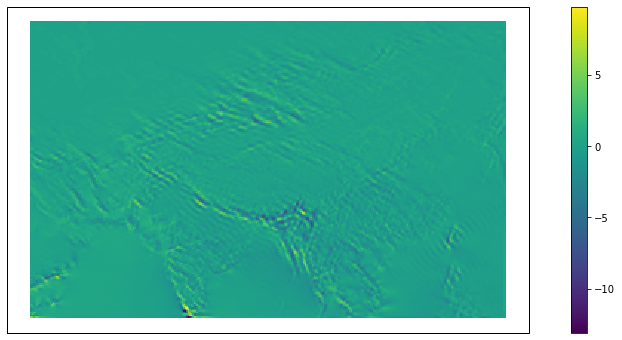

In [204]:
quick_plot(conv_mean/20* 86400* c)

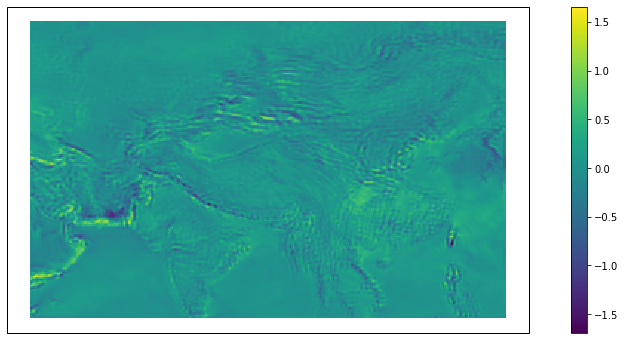

In [205]:
quick_plot(conv_eddy/20 * 86400* c)

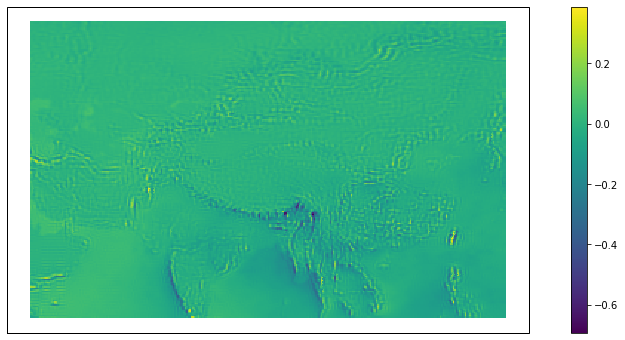

In [216]:
# for comparison 1: mean plot of vimd 
quint= xr.open_dataset('tmpdir/monthly/viwvt_1979_1982.nc')['p71.162'][0]
qvint = xr.open_dataset('tmpdir/monthly/viwvt_1979_1982.nc')['p72.162'][0]
vimd = xr.open_dataset('tmpdir/monthly/vimd_1979_1982.nc')['p84.162'][0]

quick_plot(vimd*1000)

In [ ]:
# for comparison 2: mean plot of divergence of verticaly integrated water flux